# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(123)
sns.set(font_scale=1.2)
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel, RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')


In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

Dataset contains information about 577 males and 314 females.
Females survival percent: 74.20 %
Males survival percent: 18.89 %


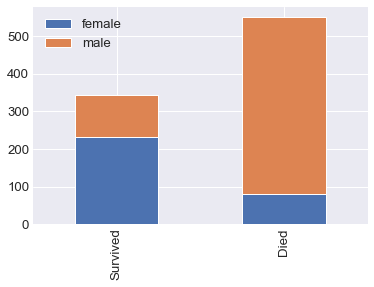

In [6]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings

warnings.filterwarnings("ignore");
plt.style.use('seaborn-darkgrid')

print("Dataset contains information about {} males and {} females.".format(*data['Sex'].value_counts()))

survived = data[data.Survived == 1].Sex.value_counts()
died = data[data.Survived == 0].Sex.value_counts()
survival_vs_gender = pd.DataFrame([survived, died], index=['Survived', 'Died'])
print("Females survival percent: {:.2f} %\nMales survival percent: {:.2f} %".format(*survival_vs_gender.apply(lambda col: col.Survived/sum(col)*100, axis=0)))
survival_vs_gender.plot(kind='bar', stacked=True, figsize=(6, 4));


**Observations:** As we can see from the plot and the percent of survived people, gender impacts the survival, i.e. females are much more likely to survive.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

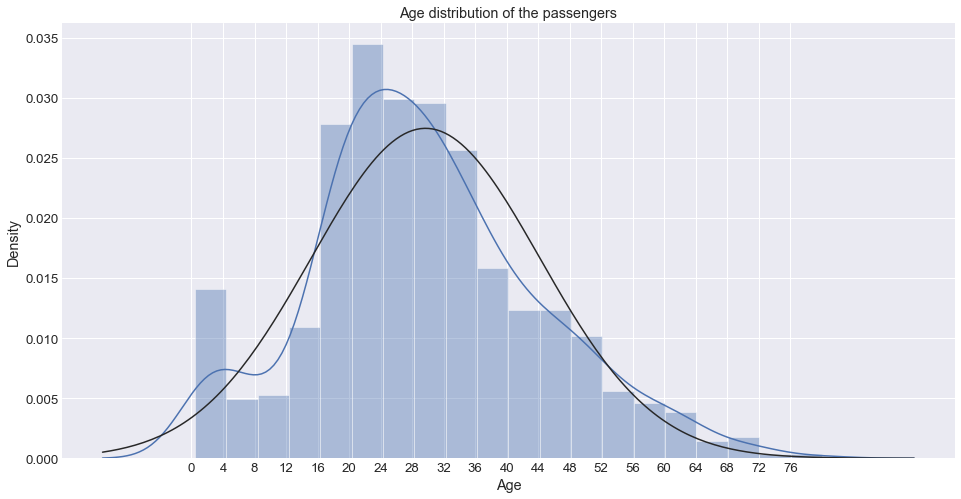

Average and median age of survived and deceased passengers:
               mean  median
Survived                   
0         30.626179    28.0
1         28.343690    28.0


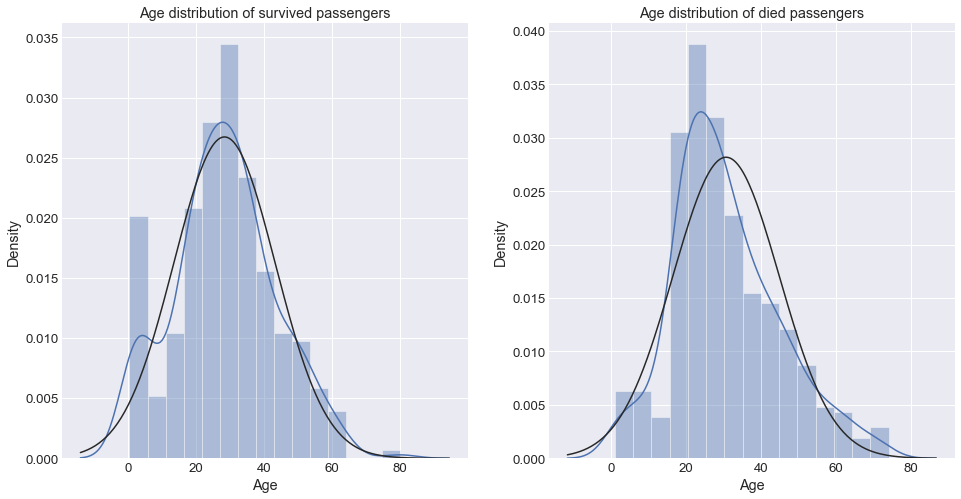

In [7]:
# 1) Plot age distribution of the passengers
plt.figure(figsize=(16,8))
ax = sns.distplot(data.Age, fit=norm, bins=20)
mids = [int(rect.get_x()) for rect in ax.patches]
ax.set_xticks(mids)
ax.set_title("Age distribution of the passengers")
plt.show()
# 2) What is the average and the median age of survived and deceased passengers
print("Average and median age of survived and deceased passengers:")
print(data.groupby('Survived').Age.agg(['mean', 'median']))
# 3) Do age distributions differ for survived and deceased passengers?
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1, 2, 1)
sns.distplot(data[data.Survived == 1].Age, fit=norm, bins=15)
ax1.set_title("Age distribution of survived passengers")
ax2 = fig.add_subplot(1, 2, 2)
sns.distplot(data[data.Survived == 0].Age, fit=norm, bins=15)
ax2.set_title("Age distribution of died passengers")
plt.show()

**Observations**: Age distribution of survived passengers is a bit different than the distribution of deceased passengers. We can see that there are more young passengers (of age 0-4) who survived. This is because of the rule "women and children first". Also we can take a look at the violin plot and see multiple distributions of data at once. Here we can see that younger males tend to survive, females survive more that males (as we saw on bar plot), passengers of age between 20-40 decease more often.

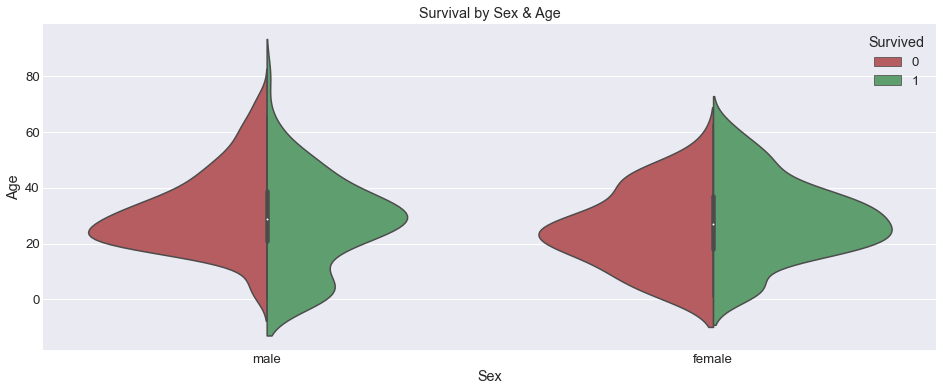

In [8]:
fig = plt.figure(figsize=(16, 6))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=data, split=True, palette={0: "r", 1: "g"})
plt.title("Survival by Sex & Age")
plt.show()

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Class 1 survival percent: 62.96 %
Class 2 survival percent: 47.28 %
Class 3 survival percent: 24.24


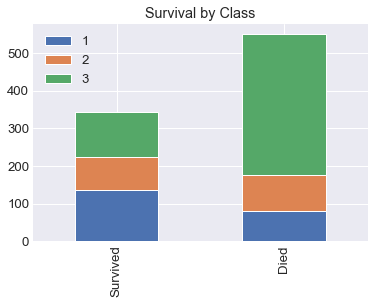

Embark S survival percent: 33.70 %
Embark C survival percent: 55.36 %
Embark Q survival percent: 38.96


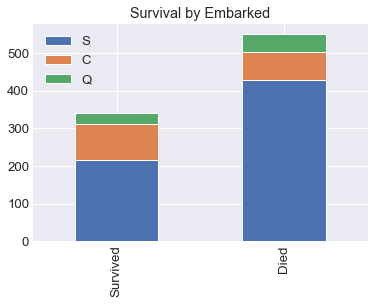

In [9]:
# Survived/Died by Class
survived_class = data[data.Survived == 1].Pclass.value_counts()
dead_class = data[data.Survived == 0].Pclass.value_counts()
survival_vs_class = pd.DataFrame([survived_class, dead_class], index=['Survived', 'Died'])
class_ratio = survival_vs_class.apply(lambda col: col.Survived/sum(col)*100, axis=0)
print("Class 1 survival percent: {:.2f} %\nClass 2 survival percent: {:.2f} %\nClass 3 survival percent: {:.2f}".format(*class_ratio))
survival_vs_class.plot(kind='bar', stacked=True, title="Survival by Class")
plt.show()

# Survived/Died by Embarked 
survived_embark = data[data.Survived == 1].Embarked.value_counts()
dead_embark = data[data.Survived == 0].Embarked.value_counts()
survival_vs_embarked = pd.DataFrame([survived_embark, dead_embark], index=['Survived', 'Died'])
embarked_ratio = survival_vs_embarked.apply(lambda col: col.Survived/sum(col)*100, axis=0)
print("Embark S survival percent: {:.2f} %\nEmbark C survival percent: {:.2f} %\nEmbark Q survival percent: {:.2f}".format(*embarked_ratio))
survival_vs_embarked.plot(kind='bar', stacked=True, title="Survival by Embarked")
plt.show()


**Observations**:  
1) What class was "the safest"? From the survival percentage we can see that 'Class 1' was the safest    
2) Is there any relationship between the embarkation port and the survival? Passengers from Embark C are more likely to survive

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [10]:
print("The percentage of missing values for each feature (train set):")
print(data.isna().sum(axis=0)/data.shape[0]*100)
print("\nThe percentage of missing values for each feature (test set):")
print(test_data.isna().sum(axis=0)/test_data.shape[0]*100)

# concat train and test dataframes for simpler preprocessing
all_data = pd.concat([data, test_data], sort=False, ignore_index=False)


The percentage of missing values for each feature (train set):
Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

The percentage of missing values for each feature (test set):
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         20.574163
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.239234
Cabin       78.229665
Embarked     0.000000
dtype: float64


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

**Observations**: we've got 3 columns with missing values: Embarked, Cabin, Age. We could use dropna strategy but we don't have much data so we need to fill missing values with some value.

- Embarked is a categorical column and we have small percent of missing values for it. We could fill missing values with just some constant value (one of S, Q, C) it wouldn't have big negative impact on our prediction. But we can try to assign Embarked based on whether passenger survived, i.e. if a passenger survived we will assign C (Embark C survival percent is the highest), and if a passenger died we will assign S (Embark S survival percent is the lowest). 

In [11]:
indexes = all_data[(all_data.Embarked.isnull())].index
all_data.loc[(all_data.Embarked.isnull()) & (all_data.Survived == 1), 'Embarked'] = 'C'
all_data.loc[(all_data.Embarked.isnull()) & (all_data.Survived == 0), 'Embarked'] = 'S'
all_data.loc[(all_data.Embarked.isnull()) & (all_data.Survived.isnull()), 'Embarked'] = 'S'
all_data.loc[indexes, ['Embarked', 'Survived']]

,Embarked,Survived
PassengerId,,
62,C,1.0
830,C,1.0


- Cabin is a categorical column and we have big percent of missing values for it, around 77%. For now we can fill missing values with some category like "Undefined". It is not accurate of course because all those passengers had some different cabin. But we can come up with some better strategy on the stage of training our model

In [12]:
all_data.loc[all_data.Cabin.isnull(), 'Cabin'] = "U"

- Fare is a numeric column and we have only one missing value for it. Let's just fill it with the mean:

In [13]:
all_data.Fare = all_data.Fare.fillna(all_data.Fare.mean())

- Age is a numeric column and we have quite a lot of missing values for it, around 19%. We can use different strategies:
    - dropping rows with missing Age. The disadvanage of such apporach is that we can miss valuable data and can get poor performance of the model. Usually it is good to have as much data as we can have.
    - fill with some negative value. This groups people with such Age value even if they don't have anything common and this can be misleading for the model.
    - fill with median strategy. This allow us to "guess" real age. The disadvanage of such approach is that we can get a bit misleading values (i.e. both child and old person may appear of age around 28, but kids was more likely to survive), therefore it could decrease the performance of our model. 
    - fill with median based on passenger's Name, Sex, Pclass etc. We can "guess" the age even more precisely if we use other available information about passenger, i.e. name contains 'Mr', 'Mrs' and etc notations. Let's investigate:

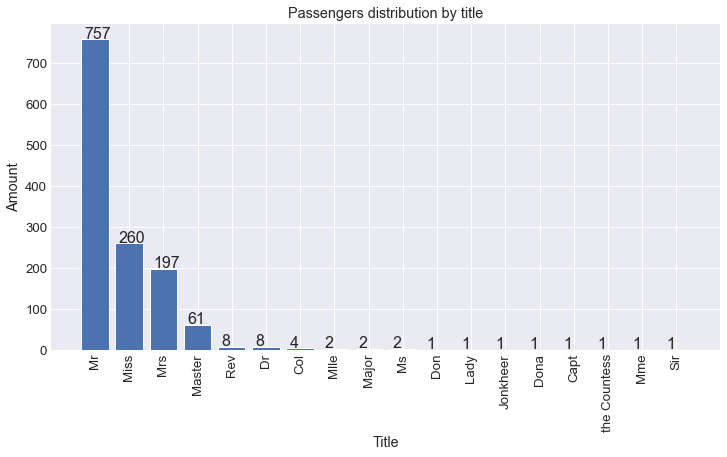

In [14]:
# extract passenger's title from Name column
second_part = all_data.Name.str.split(',').str[1]
all_data['Title'] = pd.DataFrame(second_part).Name.str.split('\.').str[0]
all_data['Title'] = all_data['Title'].str.strip()
titles = all_data.Title.value_counts()
# plot the distribution of titles
fig = plt.figure(figsize=(12, 6))
plt.bar(titles.index, titles.values)
plt.xticks(range(len(titles)), titles.index, rotation=90)
plt.title("Passengers distribution by title")
plt.xlabel("Title")
plt.ylabel("Amount")
for i, v in enumerate(titles.values):
    plt.text(i-0.3, v+2.8, str(v), size=16)
plt.show()

In [15]:
# let's simplify title
title_dict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess": "Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master", # Master is a title for an underage male
    "Lady": "Royalty"
}
all_data['Title'] = all_data.Title.map(title_dict)
print(all_data['Title'].value_counts())
age_median_by_name = all_data.groupby('Title')['Age'].median()
print("Median age within every title:")
print(age_median_by_name)
all_data.Age = all_data.apply(lambda row: age_median_by_name[row['Title']] if np.isnan(row['Age']) else row['Age'], axis=1)


Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64
Median age within every title:
Title
Master      4.0
Miss       22.0
Mr         29.0
Mrs        35.0
Officer    49.5
Royalty    39.5
Name: Age, dtype: float64


**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [16]:
y = data['Survived']
all_data.drop('Survived', axis=1, inplace=True)

In [17]:
# extract cabin type from Cabin
cabins_dict = dict((x, i) for i, x in enumerate(set(all_data.Cabin.str[0])))
all_data['Cabin_type'] = all_data.Cabin.apply(lambda cabin: cabins_dict.get(cabin[0], -1))
all_data.Parch.value_counts()

# create categorical column based on Parch and SibSp
def get_family_type(row):
    total = row.Parch + row.SibSp + 1
    if total >= 5:
        return 'Large'
    if 2 <= total <= 4:
        return 'Small'
    return 'Single'

all_data['Family_type'] = all_data.apply(get_family_type, axis=1)

# create Age category
def get_age_category(age):
    if age < 0:
        return -1 
    if 0 <= age < 4:
        return 0
    if 4 <= age < 16:
        return 1
    if 16 <= age < 36:
        return 2
    if 36 <= age < 52:
        return 3
    if 52 <= age < 64:
        return 4
    if age >= 64:
        return 5

all_data['Age_type'] = all_data.Age.apply(lambda age: get_age_category(age))

In [18]:
# split data back into train and test sets
data = all_data.head(data.shape[0]).copy()
test_data = all_data.tail(test_data.shape[0]).copy()

In [19]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['Pclass', 'Sex', 'Cabin_type', 'Embarked', 'Title', 'Family_type'] #, 'Age_type'
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [20]:
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('classifier', KNeighborsClassifier(n_neighbors=5))])
scores = cross_val_score(knn_pipeline, data, y, scoring='accuracy', cv=10)
print("Accuracy using k-neighbors: {:.4f}/{:.4f}".format(scores.mean(), scores.std()))

Accuracy using k-neighbors: 0.8261/0.0460


In [21]:
lr_l2_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('classifier', LogisticRegression(random_state=1))])
scores = cross_val_score(lr_l2_pipeline, data, y, scoring='accuracy', cv=10)
print("Accuracy using logistic regression (L2): {:.4f}/{:.4f}".format(scores.mean(), scores.std()))

Accuracy using logistic regression (L2): 0.8339/0.0330


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [22]:
def fit_plot_confusion(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    mean, std = clf.cv_results_['mean_test_score'][clf.best_index_], \
                clf.cv_results_['std_test_score'][clf.best_index_]
    print(clf.best_params_)
    disp = plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    return clf.best_estimator_, {"mean": mean, "std": std}

X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=0.4, shuffle=True, random_state=4)

0.803921568627451


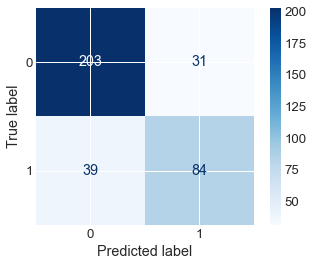

In [23]:
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('classifier', KNeighborsClassifier(n_neighbors=5))])
clf = knn_pipeline.fit(X_train, y_train)
print(accuracy_score(y_true=y_val, y_pred=clf.predict(X_val)))
disp = plot_confusion_matrix(clf, X_val, y_val, cmap=plt.cm.Blues, normalize=None)

{'knn__n_neighbors': 7, 'knn__weights': 'uniform'}


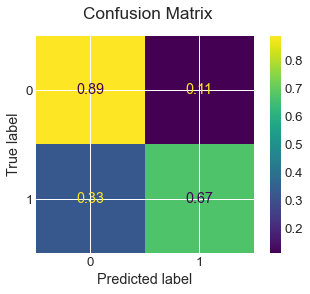

{'mean': 0.8202247191011236, 'std': 0.007945020013332013}


0.8151260504201681

In [24]:
# [1, 2, 3, 5, 30, 100]
knn_param_grid = {'knn__n_neighbors': list(range(1, 21)), 'knn__weights': ['uniform', 'distance']}

from sklearn.model_selection import GridSearchCV, StratifiedKFold

n_splits = 3
pipeline = GridSearchCV(
    Pipeline([
            ('preprocessor', preprocessor),
            ('knn', KNeighborsClassifier())
    ]),
    knn_param_grid,
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
)

pipeline.fit(X_train, y_train)
results = pipeline.cv_results_
knn_best_clf, knn_stats = fit_plot_confusion(pipeline, X_train, y_train, X_val, y_val)
print(knn_stats)
y_pred = knn_best_clf.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

{'lr__C': -0.0, 'lr__penalty': 'l1'}


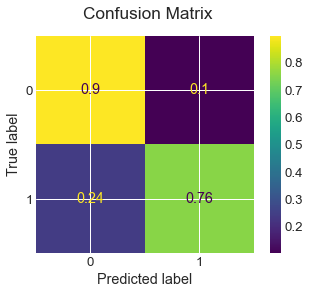

{'mean': 0.8146067415730337, 'std': 0.009174118886828404}


0.8487394957983193

In [25]:
lr_param_grid = {'lr__C': np.arange(-0.0, 1.0, 0.1), # [0.01, 0.1, 1.0, 10.0], # 
                 'lr__penalty': ['l1', 'l2']}
n_splits = 3
pipeline = GridSearchCV(
    Pipeline([
            ('preprocessor', preprocessor),
            ('lr', LogisticRegression(random_state=42, max_iter=1000, solver='saga', n_jobs=-1))
    ]),
    lr_param_grid,
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42),
    scoring='accuracy'
)
pipeline.fit(X_train, y_train)
results = pipeline.cv_results_
lr_best_clf, lr_stats = fit_plot_confusion(pipeline, X_train, y_train, X_val, y_val)
print(lr_stats)
y_pred = lr_best_clf.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

In [26]:
lr_param_grid = {'C': np.arange(0.0, 1.1, 0.1), # [0.01, 0.1, 1.0, 10.0], # 
                 'penalty': ['l1', 'l2']}

n_splits = 5
min_features_to_select = 1

clf_feature_selection = RandomForestClassifier(n_estimators=30, random_state=42, class_weight="balanced")
selector = SelectFromModel(clf_feature_selection)
# selector = RFECV(estimator=clf_feature_selection, step=1, cv=5, 
#                  min_features_to_select=min_features_to_select, scoring='accuracy')
# selector = SequentialFeatureSelector(estimator=clf_feature_selection, scoring='accuracy')
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, solver='saga', n_jobs=-1),
    param_grid=lr_param_grid,
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42),
    scoring='accuracy'
)

pipeline  = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search', grid_search)
])
pipeline_feature_selection = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', selector),
    ('grid_search', grid_search)
])
print('Cross val score: {:f}'.format(cross_val_score(pipeline, data, y, scoring='accuracy', cv=5).mean()))
print('Cross val score with feature selection: {:f}'.format(cross_val_score(pipeline_feature_selection, data, y, scoring='accuracy', cv=5).mean()))


Cross val score: 0.827155
Cross val score with feature selection: 0.791212


In [27]:
pipeline.fit(data, y)
best_model = pipeline['grid_search'].best_estimator_
print('Best score: {}'.format(pipeline['grid_search'].best_score_))
print('Best parameters: {}'.format(pipeline['grid_search'].best_params_))

Best score: 0.8338899001945892
Best parameters: {'C': 0.6000000000000001, 'penalty': 'l1'}


Train on whole dataset and save predictions to csv:

In [28]:
test_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('classifier', best_model)])
clf = test_pipeline.fit(data, y)
predictions = clf.predict(test_data)
submission = pd.DataFrame({
    "PassengerId": test_data.index,
    "Survived": predictions
})
submission.to_csv(os.path.join(PATH, 'titanic', 'titanic-submission.csv'), index=False)

My kaggle username: __liudmilash__  
My kaggle score: __0.76555__

For any questions please contact me in discord __@pandaslaw__

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code